**HACKATHON DAUPHINE / SESAMM / LFIS**

**Binary Classification**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import missingno as mno
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

import joblib
# import shap
import xgboost as xgb
import lightgbm as lgb

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, \
                                    StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, \
                            average_precision_score, recall_score, \
                            precision_score, f1_score, accuracy_score, \
                            mean_squared_error
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.utils import resample
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.kernel_approximation import Nystroem
from sklearn.calibration import CalibratedClassifierCV

from category_encoders import OneHotEncoder, TargetEncoder, OrdinalEncoder

from pprint import pprint

RANDOM_STATE = 1805

In [2]:
train_data = pd.read_csv('Data/ref_train_x.csv')
train_labels = pd.read_csv('Data/ref_train_y.csv', header=None)
test_data = pd.read_csv('Data/ref_test_x.csv')

# sp500_valid_data.columns = sp500_train_data.columns
# sp500_test_data.columns = sp500_train_data.columns

In [3]:
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)

(15249, 23)
(15249, 1)
(4191, 23)


# **Exploratory Data Analysis**

In [4]:
train_data = train_data.drop('raw_id', axis=1)

## Missing Values

In [5]:
train_data.isnull().sum().sort_values() / len(train_data)

sector                    0.000000
exchange                  0.000000
return_1y                 0.000066
return_1m                 0.000066
return_1w                 0.000066
realised_vol_1y           0.000131
realised_vol_1w           0.000197
realised_vol_1m           0.000197
implied_vol_3m            0.000328
delta_vol_1w              0.000656
publication_date_funda    0.000984
net_income                0.001115
sales                     0.001180
earnings_implied_obs      0.001312
net_debt                  0.001312
shareholders_equity       0.001377
cash_flow                 0.001705
payout_ratio              0.006164
ratio_put_call            0.006230
delta_vol_1y              0.014952
ebit                      0.122303
ebitda                    0.122565
dtype: float64

## Categorical & Numerical Variables

In [6]:
train_data.nunique().sort_values()

exchange                      2
sector                       20
publication_date_funda      401
payout_ratio               5163
earnings_implied_obs      11224
ebitda                    12262
ebit                      12264
delta_vol_1w              13004
delta_vol_1y              13588
implied_vol_3m            13659
ratio_put_call            13971
sales                     14005
cash_flow                 14010
shareholders_equity       14013
net_debt                  14014
net_income                14017
return_1w                 14075
return_1y                 14077
realised_vol_1w           14080
return_1m                 14080
realised_vol_1m           14080
realised_vol_1y           14081
dtype: int64

In [7]:
# train_data['publication_date_funda']

In [8]:
categorical_variables = ['sector']
categorical_variables_plus = ['sector']
numerical_variables = [col for col in train_data.columns if col not in categorical_variables_plus]

In [9]:
print(len(numerical_variables))
print(len(categorical_variables_plus))

21
1


## Target Distribution

In [10]:
y = train_labels.values.squeeze()

In [11]:
np.mean(y)

0.26768968456947995

# **Feature Engineering**

## Categorical Features

**One-Hot Encoding = Linear Models**

In [12]:
# %%time
# train_data_ = train_data.drop('publication_date_funda', axis=1)

# oneHotTransformer = OneHotEncoder(cols=categorical_variables)
# oneHotTransformer.fit(train_data)

# X_train_cat = oneHotTransformer.transform(train_data)
# print(X_train_cat.shape)

In [13]:
# X_train_cat['exchange'] = X_train_cat['exchange'].apply(lambda x: 1.0 if x=='US' else 0.0)

**Label Encoding = Random Forests + XGBoost + LightGBM**

In [14]:
# %%time
# labelTransformer = OrdinalEncoder(cols=categorical_variables)
# labelTransformer.fit(train_data)

# X_train_cat_label = labelTransformer.transform(train_data)
# print(X_train_cat_label.shape)

In [15]:
# X_train_cat_label['exchange'] = X_train_cat_label['exchange'].apply(lambda x: 1.0 if x=='US' else 0.0)

**Target Encoding = All Models**

In [16]:
# train_data.shape, y.shape

In [17]:
%%time
targetEncoder = TargetEncoder(cols=categorical_variables)
targetEncoder.fit(train_data, y)

X_train_cat = targetEncoder.transform(train_data)
print(X_train_cat.shape)

(15249, 22)
Wall time: 224 ms


In [18]:
X_train_cat[categorical_variables].head()

,sector
0,0.145929
1,0.145929
2,0.145929
3,0.145929
4,0.145929


In [19]:
X_train_cat['exchange'] = X_train_cat['exchange'].apply(lambda x: 1.0 if x=='US' else 0.0)

## Missing Values

In [20]:
X_train_cat.shape

(15249, 22)

In [21]:
imputer = SimpleImputer(strategy='median')
X_train_linear = imputer.fit_transform(X_train_cat)
X_train_linear = pd.DataFrame(X_train_linear, columns=X_train_cat.columns,
                              index=X_train_cat.index)

In [22]:
X_train_linear.isnull().sum().sum()

0

## Feature Scaling

In [23]:
robustScaler = RobustScaler()
X_train_linear[numerical_variables] = \
            robustScaler.fit_transform(X_train_linear[numerical_variables])

In [24]:
scaler = StandardScaler()
X_train_linear[numerical_variables] = \
            scaler.fit_transform(X_train_linear[numerical_variables])

## Feature Selection

In [25]:
df = X_train_linear.copy()
df['target'] = y

In [26]:
label_correlation = df.corr()

In [27]:
label_correlation['target'].sort_values(ascending=False)

target                    1.000000
sector                    0.109732
realised_vol_1y           0.045618
sales                     0.024218
implied_vol_3m            0.020744
ebitda                    0.018415
publication_date_funda    0.017575
ratio_put_call            0.016305
ebit                      0.012094
return_1w                 0.008004
realised_vol_1m           0.005076
net_debt                  0.004012
cash_flow                -0.000590
realised_vol_1w          -0.001610
delta_vol_1y             -0.001748
shareholders_equity      -0.002668
net_income               -0.008335
payout_ratio             -0.013110
return_1m                -0.017021
delta_vol_1w             -0.018510
exchange                 -0.027339
return_1y                -0.030697
earnings_implied_obs     -0.031238
Name: target, dtype: float64

## New Features

In [28]:
def create_new_features(X_train_linear):
    X_train_linear['ebitda / net_debt'] = X_train_linear['ebitda'] / X_train_linear['ebitda']
    X_train_linear['ebitda / cash_flow'] = X_train_linear['ebitda'] / X_train_linear['cash_flow']
    X_train_linear['ebitda / net_income'] = X_train_linear['ebitda'] / X_train_linear['net_income']
    X_train_linear['ebitda / payout_ratio'] = X_train_linear['ebitda'] / X_train_linear['payout_ratio']
    X_train_linear['ebitda / earnings_implied_obs'] = X_train_linear['ebitda'] / X_train_linear['earnings_implied_obs']

    X_train_linear['ebit / net_debt'] = X_train_linear['ebit'] / X_train_linear['net_debt']
    X_train_linear['ebit / cash_flow'] = X_train_linear['ebit'] / X_train_linear['cash_flow']
    X_train_linear['ebit / net_income'] = X_train_linear['ebit'] / X_train_linear['net_income']
    X_train_linear['ebit / payout_ratio'] = X_train_linear['ebit'] / X_train_linear['payout_ratio']
    X_train_linear['ebit / earnings_implied_obs'] = X_train_linear['ebit'] / X_train_linear['earnings_implied_obs']

    X_train_linear['earnings_implied_obs / net_debt'] = X_train_linear['earnings_implied_obs'] / X_train_linear['net_debt']
    X_train_linear['earnings_implied_obs / cash_flow'] =  X_train_linear['earnings_implied_obs'] / X_train_linear['cash_flow']
    X_train_linear['earnings_implied_obs / net_income'] =  X_train_linear['earnings_implied_obs'] / X_train_linear['net_income']
    X_train_linear['earnings_implied_obs / payout_ratio'] =  X_train_linear['earnings_implied_obs'] / X_train_linear['payout_ratio']
    
    X_train_linear['realised_vol_1y / realised_vol_1m'] = X_train_linear['realised_vol_1y'] / X_train_linear['realised_vol_1m']
    X_train_linear['realised_vol_1y / realised_vol_1w'] = X_train_linear['realised_vol_1y'] / X_train_linear['realised_vol_1w']
    X_train_linear['realised_vol_1y / publication_date_funda'] =  X_train_linear['realised_vol_1y'] / X_train_linear['publication_date_funda']
    X_train_linear['realised_vol_1y / implied_vol_3m'] =  X_train_linear['realised_vol_1y'] / X_train_linear['implied_vol_3m']
    X_train_linear['realised_vol_1y / earnings_implied_obs'] =  X_train_linear['realised_vol_1y'] / X_train_linear['earnings_implied_obs']
    X_train_linear['realised_vol_1y / return_1y'] =  X_train_linear['realised_vol_1y'] / X_train_linear['return_1y']
    X_train_linear['realised_vol_1y / delta_vol_1y'] =  X_train_linear['realised_vol_1y'] / X_train_linear['delta_vol_1y']
    
    X_train_linear['realised_vol_1w / realised_vol_1m'] = X_train_linear['realised_vol_1w'] / X_train_linear['realised_vol_1m']
    X_train_linear['realised_vol_1w / publication_date_funda'] =  X_train_linear['realised_vol_1w'] / X_train_linear['publication_date_funda']
    X_train_linear['realised_vol_1w / implied_vol_3m'] =  X_train_linear['realised_vol_1w'] / X_train_linear['implied_vol_3m']
    X_train_linear['realised_vol_1w / earnings_implied_obs'] =  X_train_linear['realised_vol_1w'] / X_train_linear['earnings_implied_obs']
    X_train_linear['realised_vol_1w / return_1m'] =  X_train_linear['realised_vol_1w'] / X_train_linear['return_1m']
    X_train_linear['realised_vol_1w / delta_vol_1w'] =  X_train_linear['realised_vol_1w'] / X_train_linear['delta_vol_1w']
    
    X_train_linear['implied_vol_3m / realised_vol_1m'] = X_train_linear['implied_vol_3m'] / X_train_linear['realised_vol_1m']
    X_train_linear['implied_vol_3m / publication_date_funda'] =  X_train_linear['implied_vol_3m'] / X_train_linear['publication_date_funda']
    X_train_linear['implied_vol_3m / earnings_implied_obs'] =  X_train_linear['implied_vol_3m'] / X_train_linear['earnings_implied_obs']
    X_train_linear['implied_vol_3m / return_1m'] =  X_train_linear['implied_vol_3m'] / X_train_linear['return_1m']
    X_train_linear['implied_vol_3m / delta_vol_1w'] =  X_train_linear['implied_vol_3m'] / X_train_linear['delta_vol_1w']
    
    return X_train_linear

In [29]:
X_train_linear = create_new_features(X_train_linear)

# **Model Training**

In [30]:
print('Training Set :\t', X_train_linear.shape)

Training Set :	 (15249, 54)


## Logistic Regression

In [31]:
logit = LogisticRegression(penalty='l1', C=100.0, solver='liblinear',
                           class_weight='balanced', random_state=RANDOM_STATE)

In [32]:
%%time
lr_scores = cross_val_score(logit, X=X_train_linear, y=y, cv=5,
                            verbose=0, scoring='roc_auc')
print(lr_scores)

[0.59950043 0.57854357 0.60864165 0.58098937 0.57948289]
Wall time: 19.1 s


In [33]:
print('Mean CV:\t', np.mean(lr_scores))
print('StDev CV:\t', np.std(lr_scores))

Mean CV:	 0.589431583926744
StDev CV:	 0.012322376182326433


In [34]:
logit.fit(X_train_linear, y);

## Random Forests

In [35]:
randomForestClassifier = RandomForestClassifier(n_estimators=200,
                                                class_weight='balanced',
                                                max_depth=6,
                                                random_state=RANDOM_STATE)

In [36]:
%%time
cv_scores = cross_val_score(randomForestClassifier, X=X_train_linear, y=y,
                            cv=5, verbose=0, scoring='roc_auc')
print(cv_scores)

[0.58401208 0.59269123 0.60135677 0.57594801 0.58040763]
Wall time: 1min 12s


In [37]:
print('Mean CV:\t', np.mean(cv_scores))
print('StDev CV:\t', np.std(cv_scores))

Mean CV:	 0.586883144860775
StDev CV:	 0.009088145750219639


In [38]:
randomForestClassifier.fit(X_train_linear, y);

## XGBoost

In [39]:
pd.Series(y).value_counts()

0    11167
1     4082
dtype: int64

In [40]:
# Reweight Imbalanced Classes
scale_pos = 11167.0 / 4082.0
print(scale_pos)
scale_pos = 3.0

2.7356687898089174


In [41]:
%%time
#nb_classes = len(np.unique(y_resampled))

xgb_train = xgb.DMatrix(X_train_linear, label=y)

xgb_hyperparameters = {'booster': 'gbtree',
                       'tree_method': 'hist',
                       'eta': 0.01,
                       'colsample_bytree': 1.0,
                       'subsample': 1.0,
                       'objective': 'binary:logistic',
                       'max_depth': 6,
                       'alpha': 3.0,
                       'lambda': 3.0,
                       #'num_class': nb_classes,
                       'eval_metric': 'auc',
                       'scale_pos_weight': scale_pos,
                       'seed': RANDOM_STATE
                      }

xgb_classifier_cv = xgb.cv(xgb_hyperparameters, xgb_train, nfold=5, maximize=True,
                           verbose_eval=5, num_boost_round=200,
                           early_stopping_rounds=None)

[0]	train-auc:0.662996+0.00264565	test-auc:0.560693+0.00802167
[5]	train-auc:0.687864+0.0103574	test-auc:0.569133+0.00567798
[10]	train-auc:0.698451+0.011926	test-auc:0.574967+0.0079036
[15]	train-auc:0.708707+0.0113386	test-auc:0.578971+0.0086647
[20]	train-auc:0.715314+0.0113372	test-auc:0.582235+0.00791142
[25]	train-auc:0.721451+0.0122531	test-auc:0.584775+0.00806702
[30]	train-auc:0.728064+0.0121327	test-auc:0.587366+0.00741894
[35]	train-auc:0.734327+0.0119387	test-auc:0.589114+0.00717195
[40]	train-auc:0.740358+0.00988566	test-auc:0.590911+0.00716881
[45]	train-auc:0.746796+0.00778806	test-auc:0.59323+0.00652701
[50]	train-auc:0.753038+0.00620372	test-auc:0.595174+0.00604056
[55]	train-auc:0.758033+0.00687237	test-auc:0.596738+0.00639609
[60]	train-auc:0.762648+0.00683111	test-auc:0.598265+0.00599057
[65]	train-auc:0.767044+0.00647244	test-auc:0.599415+0.00603064
[70]	train-auc:0.77146+0.00583325	test-auc:0.601131+0.00551869
[75]	train-auc:0.775426+0.00586956	test-auc:0.602085+0

In [42]:
class xgboostClassifier(BaseEstimator, ClassifierMixin):
    """ AAA
    """
    def __init__(self, xgb_params):
        """ AAA """
        self.xgb_params = xgb_params
        
    def fit(self, X, y, num_rounds=50, maximize=False):
        """ AAA """
        xgb_params = self.xgb_params
        xgb_train = xgb.DMatrix(X, label=y)
        clf = xgb.train(xgb_params, xgb_train, maximize=maximize,
                        verbose_eval=0, num_boost_round=num_rounds,
                        early_stopping_rounds=None)
        self.clf = clf
        return self
        
    def predict(self, X):
        """ AAA """
        clf = self.clf
        xgb_test = xgb.DMatrix(X)
        preds = clf.predict(xgb_test)
        return preds

In [43]:
%%time
nb_xgb_optimal = 200
xgb_classifier = xgboostClassifier(xgb_hyperparameters)
_ = xgb_classifier.fit(X_train_linear, y, num_rounds=nb_xgb_optimal,
                       maximize=False)

Wall time: 14 s


In [44]:
X_train_linear.shape

(15249, 54)

# **Testing Set Predictions**

## Save Models

In [45]:
joblib.dump(logit, 'MODEL_logistic_regression.pkl');
logit = joblib.load('MODEL_logistic_regression.pkl')

In [46]:
joblib.dump(randomForestClassifier, 'MODEL_random_forest.pkl');
randomForestClassifier = joblib.load('MODEL_random_forest.pkl')

In [47]:
joblib.dump(xgb_classifier, 'MODEL_xgboost.pkl');
xgb_classifier = joblib.load('MODEL_xgboost.pkl')

## Prepare Test Set

In [48]:
test_data_ = test_data.drop(['raw_id'], axis=1)
test_data_['exchange'] = test_data_['exchange'].apply(lambda x: 1.0 if x=='US' else 0.0)

In [49]:
%%time
#X_test_one_hot = oneHotTransformer.transform(test_data_)
X_test_one_hot = targetEncoder.transform(test_data_)

Wall time: 86.7 ms


In [50]:
%%time
X_test_impute = imputer.transform(X_test_one_hot)

Wall time: 2.99 ms


In [51]:
X_test_impute = pd.DataFrame(X_test_impute, columns=X_test_one_hot.columns,
                             index=X_test_one_hot.index)

In [52]:
X_test_impute[numerical_variables] = \
        robustScaler.transform(X_test_impute[numerical_variables])

In [53]:
X_test_impute[numerical_variables] = \
        scaler.transform(X_test_impute[numerical_variables])

In [54]:
X_test_linear = create_new_features(X_test_impute)

## Predictions on Test Set

In [55]:
X_test_linear.shape

(4191, 54)

In [56]:
# Logistic Regression
y_test_pred_logit = logit.predict_proba(X_test_linear)[:,1]

# Random Forests
y_test_pred_rf = randomForestClassifier.predict_proba(X_test_linear)[:,1]

# XGBoost
y_test_pred_xgb = xgb_classifier.predict(X_test_linear)

In [57]:
np.savetxt('Submits/model_qmi_41_logit.csv', y_test_pred_logit,
           fmt='%1.15f', delimiter='.')

In [58]:
np.savetxt('Submits/model_qmi_42_rf.csv', y_test_pred_rf,
           fmt='%1.15f', delimiter='.')

In [59]:
np.savetxt('Submits/model_qmi_43_xgb.csv', y_test_pred_xgb,
           fmt='%1.15f', delimiter='.')

## Stacking

https://www.kaggle.com/eliotbarr/stacking-test-sklearn-xgboost-catboost-lightgbm

In [60]:
def get_oof(clf, x_train, y_train, x_test, NFOLDS, model):
    
    ntrain = len(x_train)
    ntest = len(x_test)
    
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train, y_train)):
        x_tr = x_train.loc[train_index]
        y_tr = y_train.loc[train_index]
        x_te = x_train.loc[test_index]
        
        if model=='xgboost':
            clf.fit(x_tr, y_tr, num_rounds=200)
            oof_train[test_index] = clf.predict(x_te)
            oof_test_skf[i, :] = clf.predict(x_test)
        else:
            clf.fit(x_tr, y_tr)
            oof_train[test_index] = clf.predict_proba(x_te)[:,1]
            oof_test_skf[i, :] = clf.predict_proba(x_test)[:,1]            

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [61]:
from sklearn.model_selection import StratifiedKFold

NFOLDS = 10
kf = StratifiedKFold(n_splits = NFOLDS, shuffle=True, random_state=RANDOM_STATE)
y_series = pd.Series(y, index=X_train_linear.index)

In [62]:
%%time
logit_oof_train, logit_oof_test = get_oof(logit, X_train_linear, y_series, X_test_linear, NFOLDS, model=None)

Wall time: 24.1 s


In [63]:
%%time
rf_oof_train, rf_oof_test = get_oof(randomForestClassifier, X_train_linear, y_series, X_test_linear, NFOLDS, model=None)

Wall time: 2min 46s


In [64]:
%%time
xgb_oof_train, xgb_oof_test = get_oof(xgb_classifier, X_train_linear, y_series, X_test_linear, NFOLDS, model='xgboost')

Wall time: 2min 42s


In [65]:
x_train = np.concatenate((logit_oof_train, rf_oof_train, xgb_oof_train), axis=1)
x_test = np.concatenate((logit_oof_test, rf_oof_test, xgb_oof_test), axis=1)

In [66]:
pd.DataFrame(x_train, columns=['Logit', 'Random Forests', 'XGBoost']).corr()

,Logit,Random Forests,XGBoost
Logit,1.000000,0.692920,0.645998
Random Forests,0.692920,1.000000,0.854835
XGBoost,0.645998,0.854835,1.000000


In [67]:
meta_learner = LogisticRegression()
meta_learner.fit(x_train, y_series)
y_pred_test_stacked = meta_learner.predict_proba(x_test)[:,1]

In [68]:
np.savetxt('Submits/model_qmi_51_logit_cv.csv', logit_oof_test,
           fmt='%1.15f', delimiter='.')

In [69]:
np.savetxt('Submits/model_qmi_52_rf_cv.csv', rf_oof_test,
           fmt='%1.15f', delimiter='.')

In [70]:
np.savetxt('Submits/model_qmi_53_xgb_cv.csv', xgb_oof_test,
           fmt='%1.15f', delimiter='.')

In [71]:
np.savetxt('Submits/model_qmi_54_stacked_cv.csv', y_pred_test_stacked,
           fmt='%1.15f', delimiter='.')

## SHAP

**XGBoost**

In [72]:
import shap

In [73]:
%%time
tree_explainer = shap.TreeExplainer(model=xgb_classifier.clf)
tree_shap_values = tree_explainer.shap_values(X_test_linear)

Wall time: 9.57 s


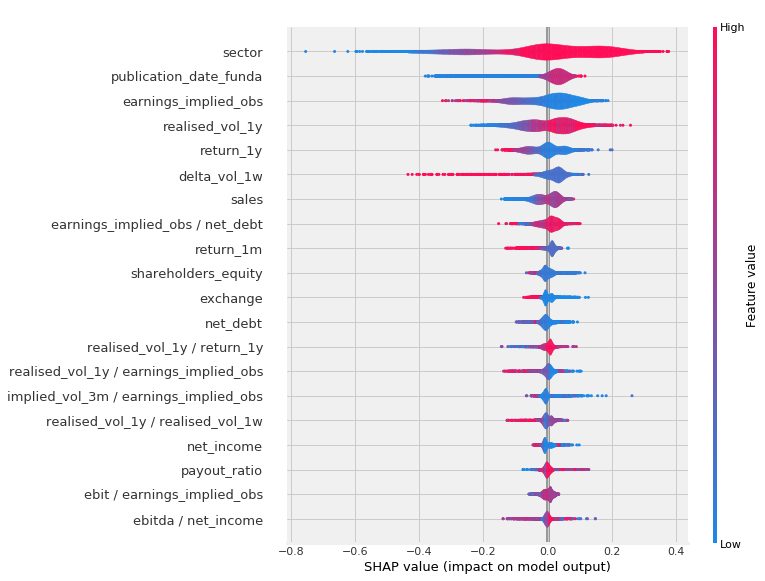

In [74]:
shap.summary_plot(tree_shap_values, features=X_test_linear,
                  feature_names=X_test_linear.columns, plot_type='violin',
                  max_display=20)

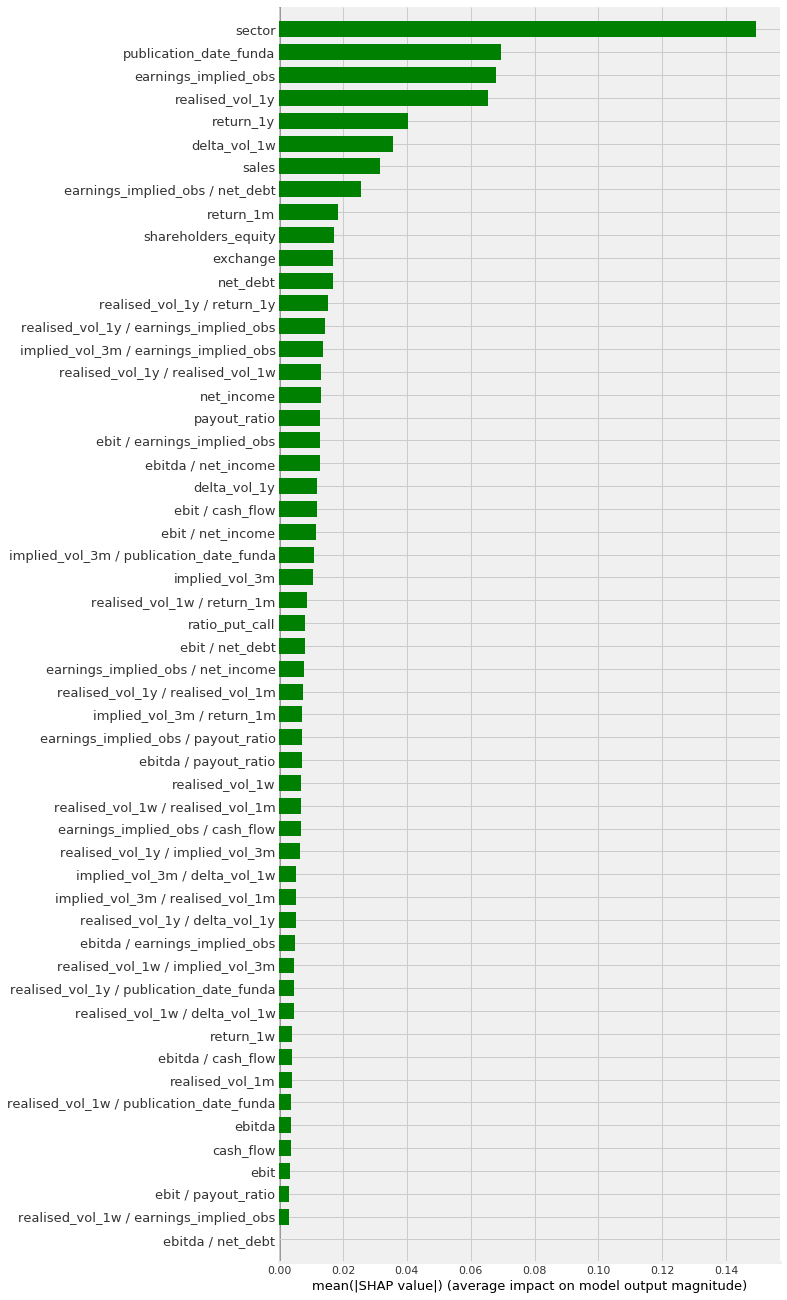

In [75]:
shap.summary_plot(tree_shap_values, features=X_test_linear,
                  feature_names=X_test_linear.columns, plot_type='bar',
                  max_display=60, color='green')

**Stacked Learner**

In [76]:
%%time
linear_explainer = shap.LinearExplainer(model=meta_learner, data=x_test)
linear_shap_values = linear_explainer.shap_values(x_test)

Wall time: 615 ms


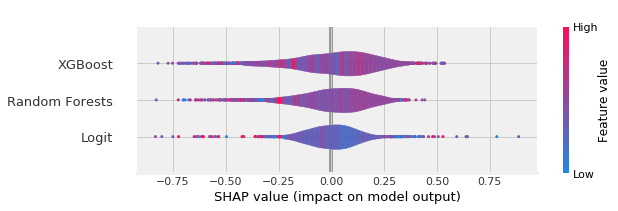

In [77]:
shap.summary_plot(linear_shap_values, features=X_test_linear,
                  feature_names=['Logit', 'Random Forests', 'XGBoost'],
                  plot_type='violin', max_display=20)

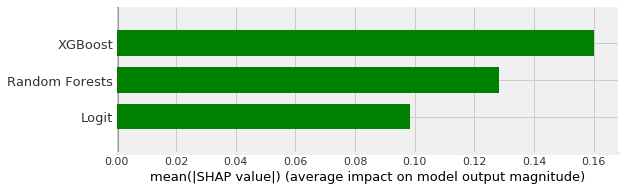

In [78]:
shap.summary_plot(linear_shap_values, features=X_test_linear,
                  feature_names=['Logit', 'Random Forests', 'XGBoost'],
                  plot_type='bar', max_display=20, color='green')